### Projeto de Programação 1 - SPAM Classification
##### Nome: Caio Alexandre Campos Maciel
##### Matrícula: 2018054680

#### Imports

In [1]:
import numpy as np
import pandas as pd

import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
from plotly.offline import iplot

from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import ConfusionMatrixDisplay

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
from keras.optimizers import RMSprop

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

from PIL import Image
from keras.utils import pad_sequences

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

2023-06-15 21:12:36.929357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 21:12:36.979032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 21:12:36.979771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 21:12:37.798630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Load Data

In [2]:
sms = pd.read_csv("spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1, names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [4]:
sms['message'].isna().any() # verifying "NULL" values

False

#### Visualizing Data

In [5]:
layout = go.Layout(title={'text':'Proportional Distribution of the Target Variable',
                         'y':0.9,
                         'x':0.5,
                         'xanchor':'center',
                         'yanchor':'top'},
                  template = 'plotly_dark')

fig = go.Figure(data=[go.Bar(
    x = ['ham', 'spam'], y = sms.groupby("label")["label"].agg("count").values,
    text = sms.groupby("label")["label"].agg("count").values, textposition = 'auto',
    marker_color = "slateblue"
)], layout = layout)

fig.show()

In [6]:
colors = ["slateblue", "darkred"]

fig = go.Figure(data=[go.Pie(labels = sms['label'].value_counts().keys(),
                             values = sms['label'].value_counts().values,
                             pull = [0, 0.25])])

fig.update_traces(hoverinfo ='label',
                  textinfo ='percent',
                  textfont_size = 20,
                  textposition ='auto',
                  marker=dict(colors=colors,
                              line = dict(color = 'lightgray',
                                          width = 1.5)))

fig.update_layout(title={'text': "Percentages of the Target Values",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly_dark')

iplot(fig, filename='basic')

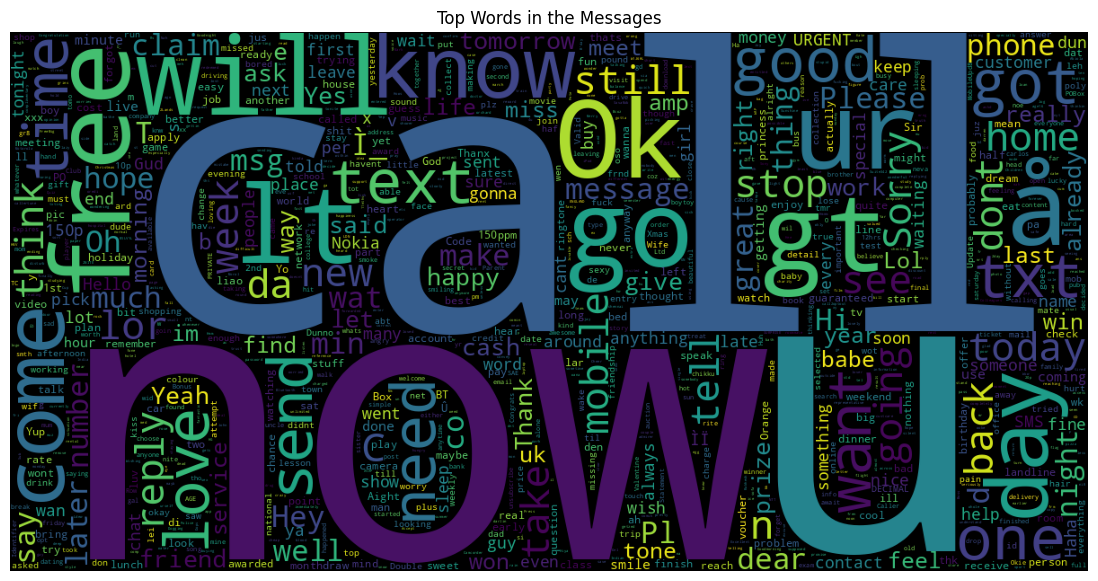

In [7]:
message = " ".join(i for i in sms.message)

wc = WordCloud(background_color = "black", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(message)

plt.figure(figsize = [15, 7])
plt.title("Top Words in the Messages")
plt.imshow(wc)
plt.axis("off")

plt.show()

#### Data Sanitization

In [8]:
# sms['msg_len'] = sms['message'].apply(lambda x: len(x.split(' ')))
# sms.head()

In [9]:
# def clean_text(text):
#     text = str(text).lower()
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)

#     return text

In [10]:
# sms['message'] = sms['message'].apply(clean_text)
# sms.head()

In [11]:
# import nltk
# # nltk.download('stopwords')
# from nltk.corpus import stopwords

# stop_words = stopwords.words("english")
# sms["message"] = sms["message"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [12]:
# stemmer = nltk.SnowballStemmer("english")
# sms["message"] = sms["message"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

#### Preparing Data to Train

In [13]:
# 80% Train and 20% Test
#features_train, features_test, labels_train, labels_test = sms['message'][0:int(0.8*(len(sms)))], sms['message'][int(0.8*(len(sms))):], \
#                                                           sms['label'][0:int(0.8*(len(sms)))], sms['label'][int(0.8*(len(sms))):]

features_train, features_test, labels_train, labels_test = train_test_split(sms.message, sms.label, test_size=0.2, random_state=42)
features_train.head()

1978    No I'm in the same boat. Still here at my moms...
3989    (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3935       They r giving a second chance to rahul dengra.
4078       O i played smash bros  &lt;#&gt;  religiously.
4086    PRIVATE! Your 2003 Account Statement for 07973...
Name: message, dtype: object

In [14]:
# Creating Train document
couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [15]:
# Number of features/tokens
trained_features = couvec.get_feature_names_out()

print("Number of Vector features/tokens:", len(trained_features))
print("Trained Features examples:", trained_features[1:10])

Number of Vector features/tokens: 7735
Trained Features examples: ['000' '000pes' '008704050406' '0089' '0121' '01223585236' '0125698789'
 '02' '0207']


In [16]:
# Tokenized train documents
dtm_train = couvec.fit_transform(features_train)

print("Shape of dtm_train:", dtm_train.shape)
#print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7735)


In [17]:
# Tokenized test documents
dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7735)


### Supervised Approach

#### Multimodal Naive Bayes

In [18]:
# O classificador multimodal Naive Bays é útil para classificar características discretas (e.g., número de palavras para classificação de textos).
# A distribuição multimodal requer geralmente contadores inteiros como features.

# Instanciando o modelo Nayve Bayes Multimodal
nb = MultinomialNB()

# Train
nb.fit(dtm_train, labels_train)

# Test
labels_pred = nb.predict(dtm_test)

##### Metrics

Class order in predict_proba: [0 1]
Class probability example: [0.99827571 0.00172429]

              precision    recall  f1-score   support

           0    0.98366   0.99793   0.99074       965
           1    0.98529   0.89333   0.93706       150

    accuracy                        0.98386      1115
   macro avg    0.98448   0.94563   0.96390      1115
weighted avg    0.98388   0.98386   0.98352      1115



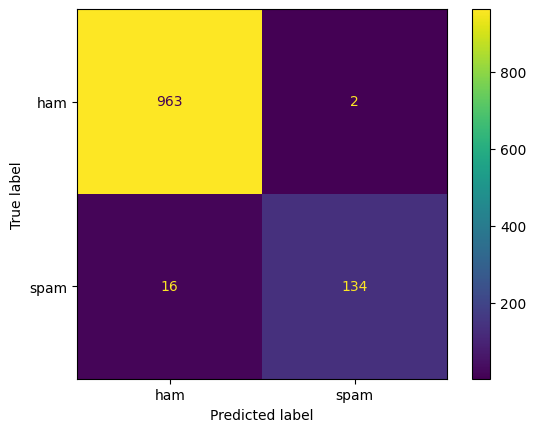

In [19]:
print(f"Class order in predict_proba: {nb.classes_}")
print(f"Class probability example: {nb.predict_proba(dtm_test)[0]}\n")

print(classification_report(y_true=labels_test, y_pred=labels_pred, digits=5))

# Confusion Matrix
cm_nb = metrics.confusion_matrix(labels_test, labels_pred) #, normalize='all'

cmd = ConfusionMatrixDisplay(cm_nb, display_labels=['ham','spam'])
cmd.plot();

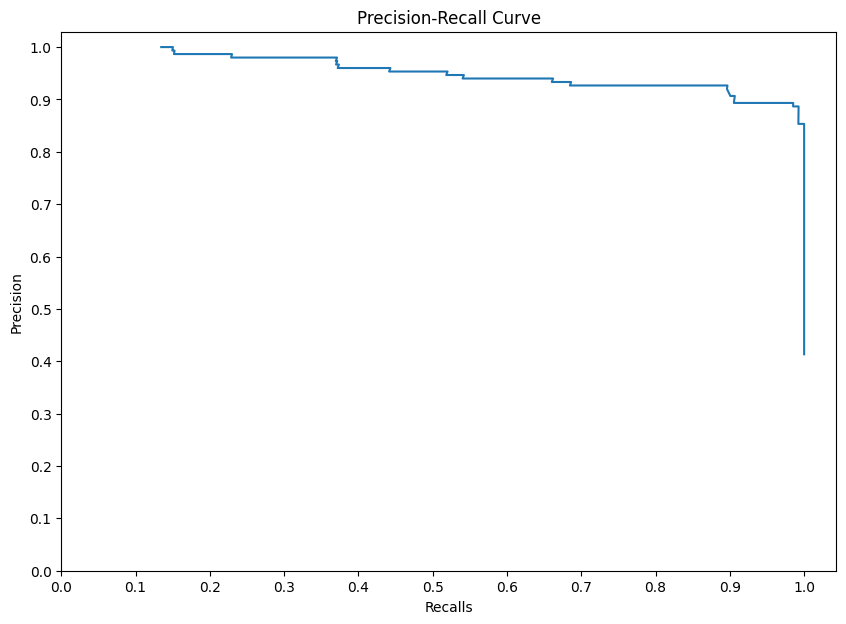

In [20]:
# Precision-Recall Curve - Imbalanced Data
labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)

plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precision")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall Curve")

plt.show()

#### LSTM

In [21]:
def LSTM_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    
    return model

In [22]:
max_words = 1000
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(features_train)

sequences = tok.texts_to_sequences(features_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [23]:
model = LSTM_model()

model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop())

2023-06-15 21:12:50.723789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-15 21:12:50.723829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pop-os
2023-06-15 21:12:50.723836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pop-os
2023-06-15 21:12:50.724032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.116.4
2023-06-15 21:12:50.724063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-06-15 21:12:50.724082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.105.17 does not match DSO version 525.116.4 -- cannot find working devices in this configuration
2023-06-15 21:12

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

2023-06-15 21:12:50.942184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 21:12:50.944002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]


In [24]:
# Fit Train Data
history = model.fit(sequences_matrix, labels_train,
                                        batch_size=128,
                                        epochs=10,
                                        validation_split=0.2,
                                        shuffle=False,
                                        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)]).history

Epoch 1/10


2023-06-15 21:12:51.353623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 21:12:51.355462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 21:12:51.356742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - ETA: 0s - loss: 0.3417

2023-06-15 21:12:55.568256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 21:12:55.569904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 21:12:55.571238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 5s 109ms/step - loss: 0.3417 - val_loss: 0.1645
Epoch 2/10
28/28 [==============================] - 2s 86ms/step - loss: 0.0926 - val_loss: 0.0643
Epoch 3/10
28/28 [==============================] - 2s 89ms/step - loss: 0.0425 - val_loss: 0.0451
Epoch 4/10
28/28 [==============================] - 3s 94ms/step - loss: 0.0314 - val_loss: 0.0440
Epoch 5/10
28/28 [==============================] - 2s 83ms/step - loss: 0.0234 - val_loss: 0.0429
Epoch 6/10
28/28 [==============================] - 2s 88ms/step - loss: 0.0160 - val_loss: 0.0480


##### Metrics

In [25]:
train_sequences = tok.texts_to_sequences(features_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)

y_pred_train = model.predict(train_sequences_matrix, verbose=0)

# print(f'\n\nTrain Accuracy: {metrics.accuracy_score(labels_train, y_pred_train.round()):.5f}')

2023-06-15 21:13:13.481360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-15 21:13:13.482915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-15 21:13:13.484237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

              precision    recall  f1-score   support

           0    0.98653   0.98653   0.98653       965
           1    0.91333   0.91333   0.91333       150

    accuracy                        0.97668      1115
   macro avg    0.94993   0.94993   0.94993      1115
weighted avg    0.97668   0.97668   0.97668      1115



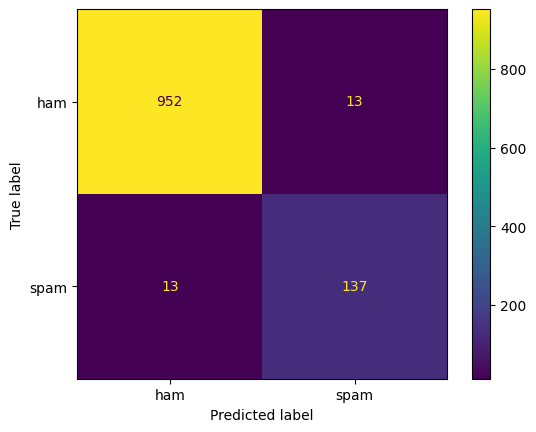

In [26]:
# Predict on Test Data
test_sequences = tok.texts_to_sequences(features_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)


y_pred_lstm = model.predict(test_sequences_matrix, verbose=0)

print(classification_report(y_true=labels_test, y_pred=y_pred_lstm.round(), digits=5))

# Confusion Matrix
cm = metrics.confusion_matrix(labels_test, y_pred_lstm.round()) # ,normalize='all']

cmd = ConfusionMatrixDisplay(cm, display_labels=['ham','spam'])
cmd.plot();

#### XGBoost

In [27]:
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        eval_metric='auc',
    ))
])

##### Metrics

In [28]:
# Fit and Predict on Data
pipe.fit(features_train, labels_train)

y_pred_train = pipe.predict(features_train)
y_pred_test = pipe.predict(features_test)

print('Train: {}'.format(metrics.accuracy_score(labels_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(labels_test, y_pred_test)))

Train: 0.9928202827013687
Test: 0.9739910313901345


              precision    recall  f1-score   support

           0    0.97273   0.99793   0.98517       965
           1    0.98400   0.82000   0.89455       150

    accuracy                        0.97399      1115
   macro avg    0.97836   0.90896   0.93986      1115
weighted avg    0.97424   0.97399   0.97298      1115



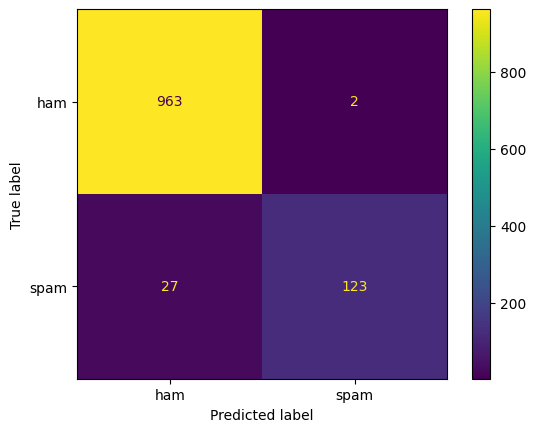

In [29]:
print(classification_report(y_true=labels_test, y_pred=y_pred_test, digits=5))

# Confusion Matrix
cm_xg = metrics.confusion_matrix(labels_test, y_pred_test) # , normalize='all'

cmd = ConfusionMatrixDisplay(cm_xg, display_labels=['ham','spam'])
cmd.plot();

#### Logistic Regression

In [30]:
corpus = []

for i in range(len(sms)):
    review = re.sub("[^a-zA-Z]", " ", sms["message"][i])
    review = review.lower()
    review = review.split()
    review = ' '.join(review)
    corpus.append(review)

In [31]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = pd.get_dummies(sms.label, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.20, random_state=0)

##### Fit and Predict

In [32]:
clf_lr = LogisticRegression(solver="liblinear", C=10, penalty="l2")

clf_lr.fit(X_train, y_train)
pred_lr = clf_lr.predict(X_test)

##### Metrics

              precision    recall  f1-score   support

       False    0.98439   0.99684   0.99058       949
        True    0.98052   0.90964   0.94375       166

    accuracy                        0.98386      1115
   macro avg    0.98246   0.95324   0.96716      1115
weighted avg    0.98381   0.98386   0.98360      1115



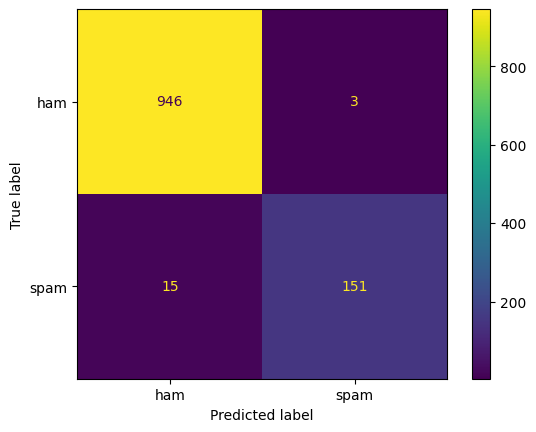

In [33]:
print(classification_report(y_test, pred_lr, digits=5))

cm_lr = metrics.confusion_matrix(y_test, pred_lr) # , normalize='all'

cmd = ConfusionMatrixDisplay(cm_lr, display_labels=['ham','spam'])
cmd.plot();

### Unsupervised Approach

#### KNN

In [34]:
knc = KNeighborsClassifier(n_neighbors=1)

knc.fit(dtm_train, labels_train)
pred_knn = knc.predict(dtm_test)

##### Metrics

              precision    recall  f1-score   support

           0    0.95262   1.00000   0.97573       965
           1    1.00000   0.68000   0.80952       150

    accuracy                        0.95695      1115
   macro avg    0.97631   0.84000   0.89263      1115
weighted avg    0.95899   0.95695   0.95337      1115



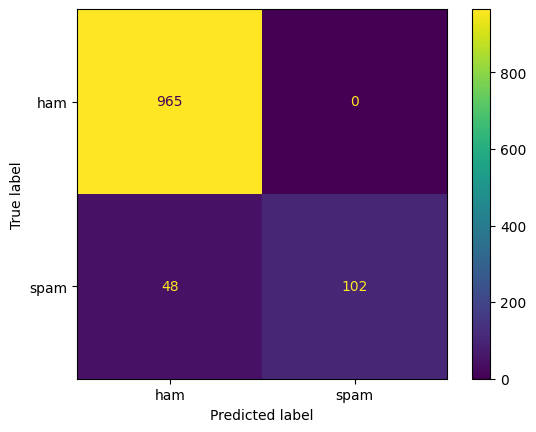

In [35]:
print(classification_report(labels_test, pred_knn, digits=5))

cm_knn = metrics.confusion_matrix(labels_test, pred_knn) # , normalize='all'

cmd = ConfusionMatrixDisplay(cm_knn, display_labels=['ham','spam'])
cmd.plot();